# Beta-project - Using AI to classify climbing problems

Climbing is a sportive discipline where participants must... climb, either indoor or outdoor. Here, we tackle indoor climbing: a wall contains holds, and the climber must only use some of them. A difficulty ("grade") is attributed following the pattern: (number in range 5-9)(letter in range a-c)(nothing or a + symbol) (for example: 5c+ or 8b).

The goal is to predict the grade of the route only using its physical properties, and not the feeling of the climber. We use Deep Learning algorithms inside a global Data science method to solve this problem.

This project uses data from [Moonboard](https://moonclimbing.com/moonboard), a climbing board with customizable routes: holds that the climber can use are shown with LEDs. Thus, there is a great amount of possible routes, that can be graded by everyone using the Moonboard app. We'll thus consider that grades contained in this database are relevant, and we'll train and test our models against this data.

TODO:
- use k-fold (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold ?)
- make merged graphics
- re-test every model and significant variations in order to show the effect of different techniques and their combination
- Do a better under-sampling (just removing some samples from majority class, and test training with max 1000 images per class) (add some data augmentation?)

# General data consideration

We start our project by importing relevant Python libraries, for data science, visualization and machine learning. We'll tackle explainability later.

In [40]:
import json
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from IPython.display import Image

## Download and import data

We use an [extracted database](https://github.com/spookykat/MoonBoard/issues/6#issuecomment-1783515787) found on GitHub.

We first download everything and import raw data, except the "problems.json" that mostly contains duplicates of the Masters 2019 dataset.

We include the Mini MoonBoard dataset, as it contains many routes that are still relevant to our problem. The model we'll use will not take into account the size of the route but rather local patterns.

We only include columns that will be relevant for our classification problem, i.e. data that influence a route's grade.

In [ ]:
!wget https://github.com/spookykat/MoonBoard/files/13193317/problems_2023_01_30.zip
!unzip problems_2023_01_30 -d problems_2023_01_30

In [2]:
columns = {
  "apiId": int,
  "name": str,
  "grade": 'category',
  "userGrade": 'category',
  "method": 'category',
  "holdsetup": 'category',
  "holdsets": 'object',
  "moves": 'object',
  "angle": int
}
column_names = list(columns.keys())

df = pd.DataFrame(columns=column_names)

for filename in os.listdir('problems_2023_01_30'):
  if filename == 'problems.json':
    continue
  
  with open(os.path.join('problems_2023_01_30', filename), 'r') as f:
    data = json.load(f)
    local_df = pd.DataFrame(data["data"])
    angle = int(filename.rstrip('.json').split()[-1])
    local_df['angle'] = angle if angle < 90 else 40
    df = pd.concat([df, local_df[column_names]])
      
df.drop_duplicates(keep='first', subset='apiId', inplace=True)
df.set_index('apiId', inplace=True)

## Parse fields

### Fields with foreign relations

In [3]:
df["holdsetup"] = df["holdsetup"].map(lambda x: x['apiId'])
df["holdsets"] = df["holdsets"].map(lambda sets: [el['apiId'] for el in sets])

### Moves: all holds of the route

There are three types of holds:

- Starter hold: where to put hands at the beginning
- Middle hold
- End hold: where to put both hands for at least 3 seconds at the end of the route

In [4]:
WIDTH = 11
HEIGHT = 18
NUM_HOLD_TYPES = 3

MOVES_SHAPE=(WIDTH, HEIGHT, NUM_HOLD_TYPES)

def parse_holds(moves):
  holds = np.zeros(MOVES_SHAPE, dtype=np.uint8)
  for hold in moves:
    description = hold['description']
    column = ord(description[0].upper()) - ord('A')
    row = int(description[1:]) - 1
    channel = 0
    if hold['isStart']:
      channel = 1
    if hold['isEnd']:
      channel = 2
    holds[column, row, channel] = 1
  return holds


df["moves"] = df["moves"].map(parse_holds)

### Merging "grade" and "userGrade"

When a userGrade is present, it means that enough users rated this route so we assume this is a more objective metric than opener's grade attribution.

In [5]:
df["grade"] = df["userGrade"].combine_first(df["grade"]).astype('category')
df.drop("userGrade", axis=1, inplace=True)

### Putting the right dtypes

In [6]:
for column in df.columns:
  df[column] = df[column].astype(columns[column])

### Empty data

In [7]:
df.isna().sum()

name         0
grade        0
method       0
holdsetup    0
holdsets     0
moves        0
angle        0
dtype: int64

There is no empty data, but one can uncomment the code below if any shows up.

In [8]:
# df.select_dtypes(include=[int, float]).fillna(df.mean(), inplace=True)
# categories = df.select_dtypes(include=['category', 'object'])
# categories.fillna(categories.mode().iloc[0])

# Data Visualization and analysis

## Overall information

In [9]:
df.describe()

,angle
count,143100.000000
mean,38.548952
std,4.433996
min,25.000000
25%,40.000000
50%,40.000000
75%,40.000000
max,40.000000


In [10]:
df['holdsets'].value_counts()

holdsets
[3, 4, 5]          32702
[4, 5]             24720
[4, 5, 8]          12873
[3, 4, 5, 8]        8615
[3, 4, 5, 8, 9]     4963
                   ...  
[5, 9, 11]            53
[10]                  50
[5, 11]               47
[5, 9, 10]            43
[5, 10]               31
Name: count, Length: 78, dtype: int64

In [11]:
df['holdsetup'].value_counts()

holdsetup
1     59506
15    55122
17    24802
19     3670
Name: count, dtype: int64

In [12]:
all_grades = list(df['grade'].cat.categories)
all_grades

['5+',
 '6A',
 '6A+',
 '6B',
 '6B+',
 '6C',
 '6C+',
 '7A',
 '7A+',
 '7B',
 '7B+',
 '7C',
 '7C+',
 '8A',
 '8A+',
 '8B',
 '8B+']

## Visualize routes

We plot some of the routes to better visualize their structure. The plot will not be in the same orientation, due to the array structure: the left side is the bottom of the route.

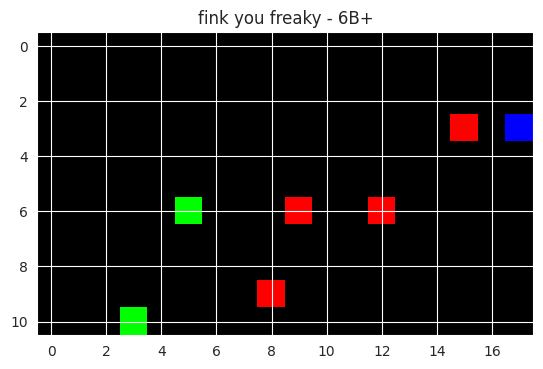

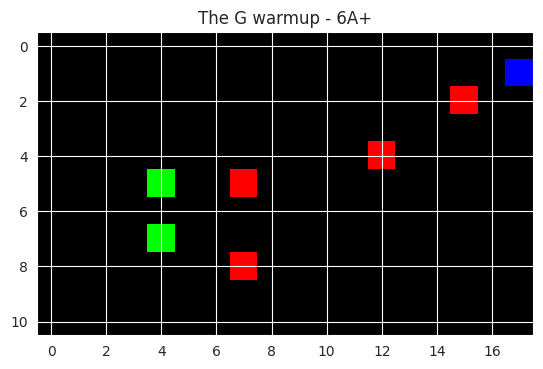

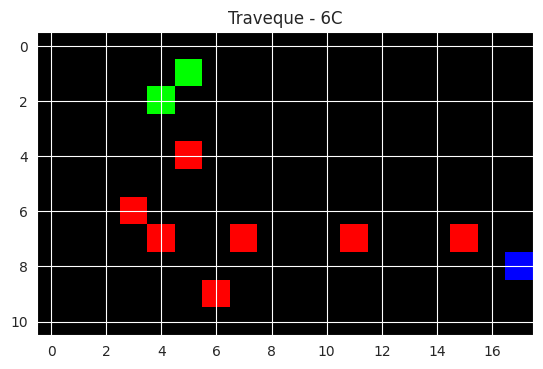

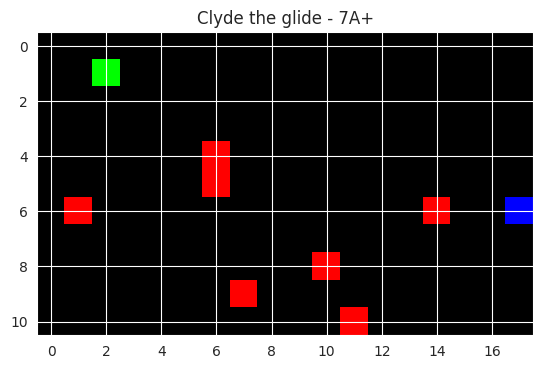

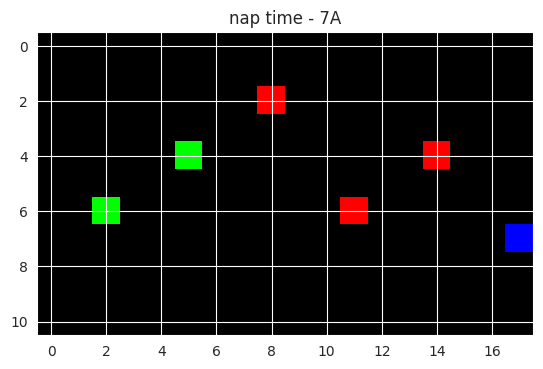

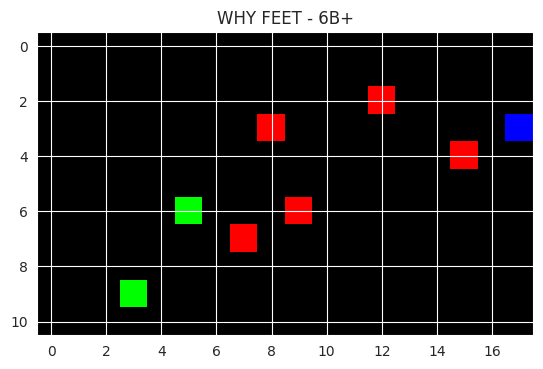

In [13]:
for _, route in df.sample(n=6).iterrows():
  plt.imshow(route['moves'] * 255)
  plt.title(f"{route['name']} - {route['grade']}")
  plt.show()

## Plot the distribution of classes

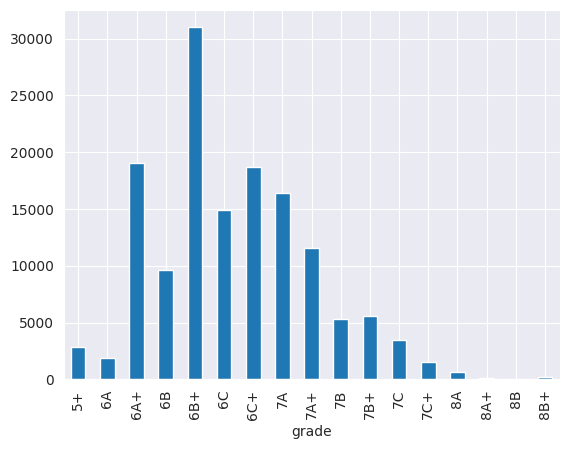

In [14]:
def plot_category_hist(dataframe, cat):
  dataframe[cat].value_counts().sort_index().plot(kind='bar')

plot_category_hist(df, "grade")

Middle-grade routes are over-represented, with 6B+ routes being clearly omnipresent.

## Check the influence of the resolution method

Let's see another field: "method", describing how the climber should physically solve the problem. This can significantly influence the difficulty and feasibility of a route.

In [15]:
df.groupby('method').size() / len(df)

/tmp/ipykernel_38365/647761904.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('method').size() / len(df)


method
Feet follow hands                0.961579
Feet follow hands + screw ons    0.025618
Footless                         0.000021
Footless + kickboard             0.009553
Screw ons only                   0.003229
dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, '5+'),
  Text(1, 0, '6A'),
  Text(2, 0, '6A+'),
  Text(3, 0, '6B'),
  Text(4, 0, '6B+'),
  Text(5, 0, '6C'),
  Text(6, 0, '6C+'),
  Text(7, 0, '7A'),
  Text(8, 0, '7A+'),
  Text(9, 0, '7B'),
  Text(10, 0, '7B+'),
  Text(11, 0, '7C'),
  Text(12, 0, '7C+'),
  Text(13, 0, '8A'),
  Text(14, 0, '8A+'),
  Text(15, 0, '8B'),
  Text(16, 0, '8B+')])

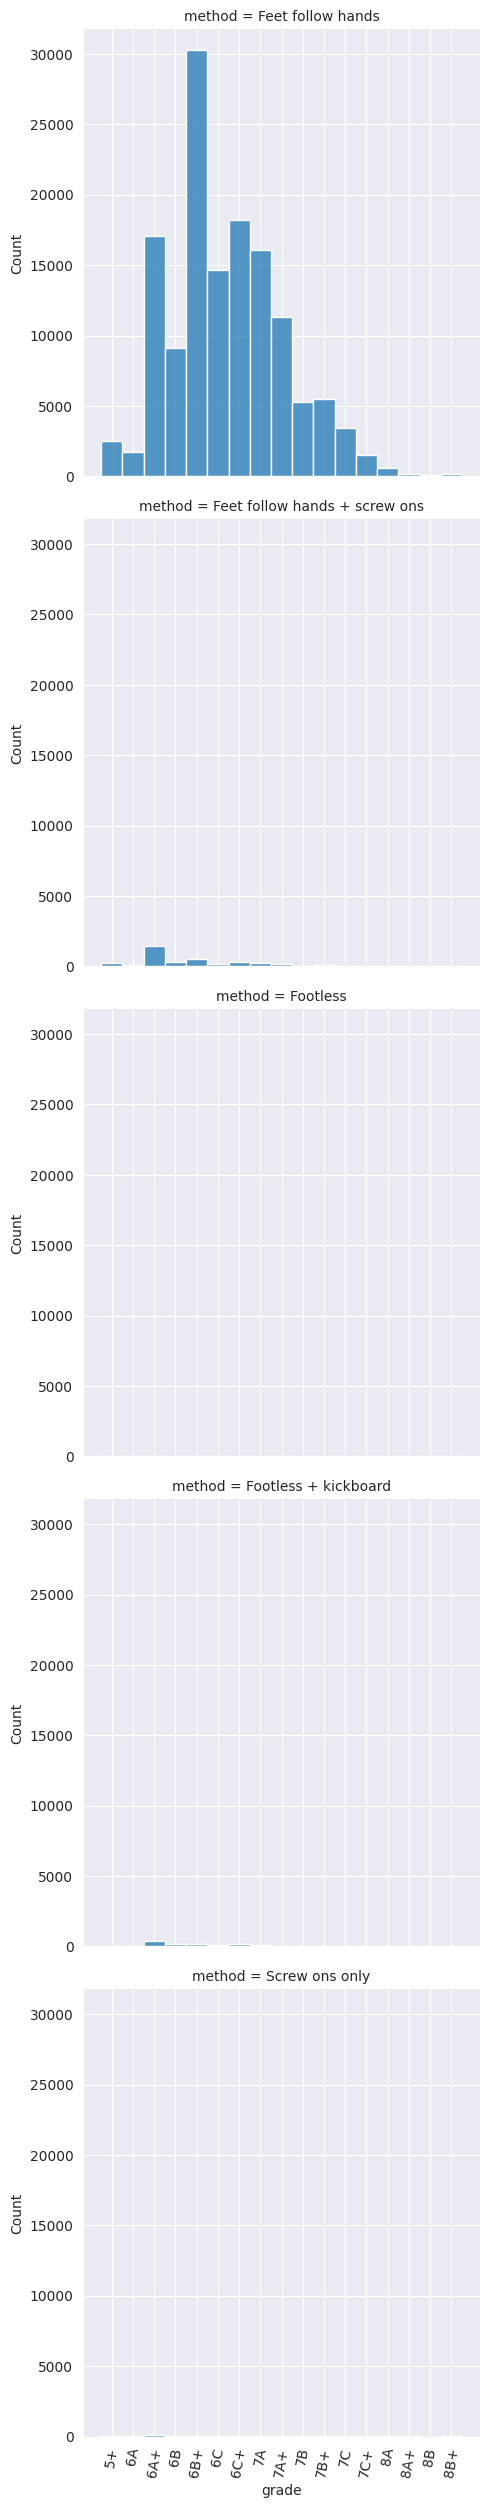

In [16]:
nb_methods = len(df['method'].dtype.categories)

sns.displot(data=df, x='grade', row='method')
plt.xticks(rotation=80)

# Data Preparation

We now want to prepare our data specifically for Machine Learning. We'll apply several well-known techniques, such as encoding (one-hot, rare...) and normalization, in order for our models to learn as much relevant data as possible to generalize well. We'll finish by splitting the data into training and testing sets - the validation set is created directly when training a new model.

## Separate features and labels

We keep `moves` separate, as it's a special data type that we can tackle in many different ways. We'll see later two views: as a simple sequence, or as images.

In [17]:
features = df.drop(columns=['moves', 'grade', 'name'])
moves = df['moves']
labels = df['grade']

## Rare encoding

For each categorical feature, we group together categories that appear less than 1% of the time.

For instance, the `method` feature has a clear imbalance: thus values `footless`, `footless + kickboard` and `screw ons only` must be gathered together. We can see this group as "difficult", as the climber is not allowed to use their feet for these routes.

In [18]:
rare_threshold = 0.1

for col in features.select_dtypes(include=['category']):
  value_counts = features[col].value_counts()
  rare_values = list(value_counts[value_counts / len(features) < rare_threshold].index)
  if len(rare_values) > 1:
    features[col] = features[col].cat.add_categories(['Rare'])
    features.loc[features[col].isin(rare_values), col] = 'Rare'
    features[col] = features[col].cat.remove_unused_categories()

## One-hot encoding

Before going further, we need to convert all features except 'moves' to numerical ones.

### Dealing with the `holdsets` feature

This field contain arrays of holdsets, so we'll use a one-hot encoding to indicate for each holdset if a route contains it.

In [19]:
# TODO: use https://scikit-learn.org/stable/modules/preprocessing_targets.html ?

def flatten_array(arr):
  result = []
  for el in arr:
    result.extend(el)
  return result

all_sets = list(features['holdsets'].value_counts().index)
all_sets = flatten_array(all_sets)
all_sets = list(set(all_sets))

for i in all_sets:
  features[f'holdset_{i}'] = False

In [20]:
def encode_sets(x):
  for i in x['holdsets']:
    x[f'holdset_{i}'] = True
  return x
  
features = features.apply(encode_sets, axis=1)
features.drop(columns=['holdsets'], inplace=True)

### Dealing with other features

We use a basic one-hot encoding for other features, which is done quickly using pandas.

In [21]:
features['holdsetup'] = features['holdsetup'].astype('category')
features = pd.get_dummies(features)

labels = pd.get_dummies(labels)

Now that we have all the columns, we can get the number of distinct features and labels:

In [22]:
nb_labels = len(labels.columns)
nb_features = len(features.columns)

## Normalization

We use min-max normalization, as the distribution of numerical inputs (i.e. `angle`) is not normal.

In [23]:
for col in features.select_dtypes(include=[int, float]):
  features[col] = (features[col] - features[col].min()) / (features[col].max() - features[col].min())

## Split into train and test datasets

As explained earlier, the validation dataset will be created directly when fitting the model.

In [24]:
from sklearn.model_selection import train_test_split

test_split = 0.2

train_features, test_features, train_moves, test_moves, train_labels, test_labels = train_test_split(
  features,
  moves,
  labels,
  test_size=test_split,
  stratify=labels,
)

train_moves = np.stack(train_moves.values)
test_moves = np.stack(test_moves.values)

# Helpers to build, train and analyse models

In this part, we define some helpers functions that we are going to reuse for all models : from building a model to analysing results.

## Skeleton: build and fit model

We first define a function to plot a model, which can be useful to verify the connections made, especially as our models will not be sequential.

In [25]:
def plot_model(model):
  keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    expand_nested=True
  )

For all models, we use the Categorical Crossentropy by default, as we face a multi-label classification problem, but where each object only has a unique class.

We also use different accuracy metrics not to rely only on the basic accuracy. Indeed, in the reality of climbing, it is okay to be one grade off - in many cases, the climber won't really notice the difference.

In [26]:
def compile_model(
        model=None,
        build_function=None,
        learning_rate=1e-3,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=None):

    if model is None:
        model = build_function()

    if metrics is None:
        metrics=[]

    metrics.extend([
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.TopKCategoricalAccuracy(k=3, name='accuracy_at_three'),
      keras.metrics.TopKCategoricalAccuracy(k=5, name='accuracy_at_five')
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=metrics
    )
    return model

Finally, we create the function to train models. We use several callbacks to save our models at intermediary and "best-accuracy" stages, as well as exporting data for TensorBoard. This will allow us to precisely analyse our results and plot relevant graphs.

In [27]:
def train_model(model,
                training_features,
                training_labels,
                epochs=100,
                callbacks=None,
                early_stopping=None,
                validation_split=0.2,
                batch_size=64,
                class_weight=None,
                name='model',
                log_dir='logs/fit'
                ):

    if callbacks is None:
        callbacks = []
        
    if early_stopping is not None:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='loss', patience=early_stopping))

    date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks.extend([
      keras.callbacks.ModelCheckpoint(f'models/{name}-{date}-{{epoch:02d}}-{{val_loss:.2f}}.keras'),
      keras.callbacks.ModelCheckpoint(f'models/{name}-{date}-best.keras', save_best_only=True, monitor='val_loss'),
      keras.callbacks.BackupAndRestore(backup_dir=f'/tmp/backup/{name}--{date}'),
      keras.callbacks.TensorBoard(log_dir=f'{log_dir}/{name}--{date}', histogram_freq=1)
    ])
    
    model.fit(
      training_features,
      training_labels,
      epochs=epochs,
      callbacks=callbacks,
      validation_split=validation_split,
      batch_size=batch_size,
      class_weight=class_weight,
    )
    return model

## Skeleton: overall accuracy

In [28]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [29]:
def parse_prediction(model, moves, features, labels):
  probabilities_labels = model.predict([moves, features], verbose=0)
  y_true = np.argmax(labels, axis=1)
  y_pred = np.argmax(probabilities_labels, axis=1)
  predicted = np.zeros_like(probabilities_labels).astype(bool)
  predicted[np.arange(probabilities_labels.shape[0]), y_pred] = True
  
  return predicted, y_true, y_pred
  
  
def load_best_model(
        name='model',    
  ):
    best_model = keras.models.load_model(f'models/{name}-best.keras')
    train_predicted, train_y_true, train_y_pred = parse_prediction(best_model, train_moves, train_features, train_labels)
    test_predicted, test_y_true, test_y_pred = parse_prediction(best_model, test_moves, test_features, test_labels)
    
    return best_model, train_predicted, train_y_true, train_y_pred, test_predicted, test_y_true, test_y_pred

In [30]:
def print_accuracies(model, y_true, y_pred):
  metrics = model.evaluate([test_moves, test_features], test_labels, verbose=0)
  print(f'Accuracy: {metrics[1] * 100:.2f}%')
  print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred) * 100:.2f}%')
  print(f'Accuracy for Top3: {metrics[2] * 100:.2f}%')
  print(f'Accuracy for Top5: {metrics[3] * 100:.2f}%')

In [31]:
def confusion_matrix_analysis(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
  per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
  for i, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for grade {all_grades[i]}: {acc * 100:.2f}%")
  
  plt.figure(figsize=(15, 10))
  sns.heatmap(cm_normalized,  annot=True, fmt='.2f', cmap='rocket')
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Normalized Confusion Matrix")
  plt.show()

## Skeleton: one-vs-rest analysis

In [32]:
def create_one_vs_rest_plot(xlabel, ylabel):
  fig, axs = plt.subplots(nrows=nb_labels, ncols=1, sharex=True)
  fig.set_size_inches(6, 4 * nb_labels)
  fig.text(0.5, 0.0005, xlabel, ha='center')
  fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical')
  return fig, axs

In [33]:
from sklearn.metrics import roc_curve

def one_vs_rest_roc_curve(train_predicted, test_predicted):
  fig, axs = create_one_vs_rest_plot('False Positive Rate', 'True Positive Rate')
  
  for i in range(nb_labels):
    train_fpr, train_tpr, _ = roc_curve(train_labels.values[:, i], train_predicted[:, i])
    test_fpr, test_tpr, _ = roc_curve(test_labels.values[:, i], test_predicted[:, i])
    plt.sca(axs[i])
    sns.lineplot(x=train_fpr, y=train_tpr, label='Train', ax=axs[i])
    sns.lineplot(x=test_fpr, y=test_tpr, label='Test', ax=axs[i])
    plt.ylabel(all_grades[i])
    
  fig.tight_layout()

In [34]:
from sklearn.metrics import precision_recall_curve

def one_vs_rest_precision_recall_curve(train_predicted, test_predicted):
  fig, axs = create_one_vs_rest_plot('False Positive Rate', 'True Positive Rate')
    
  for i in range(nb_labels):
    train_precision, train_recall, _ = precision_recall_curve(train_labels.values[:, i], train_predicted[:, i])
    test_precision, test_recall, _ = precision_recall_curve(test_labels.values[:, i], test_predicted[:, i])
    plt.sca(axs[i])
    sns.lineplot(x=train_precision, y=train_recall, ax=axs[i])
    sns.lineplot(x=test_precision, y=test_recall, ax=axs[i])
    plt.ylabel(all_grades[i])
      
  fig.tight_layout()

# Baseline

For the baseline, we'll use a simple neural network with only Dense layers. We could even go simpler, but our final goal here is to implement a Deep Learning technique, so we only compare these kinds of algorithms.

In [36]:
def create_baseline():
  moves_inputs = keras.Input(shape=MOVES_SHAPE, name="moves")
  features_inputs = keras.Input(shape=(nb_features,), name="features")
  
  x = keras.layers.Flatten()(moves_inputs)
  
  x = keras.layers.concatenate([x, features_inputs])
  
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(nb_labels, activation='softmax')(x)
  
  return keras.Model(inputs=[moves_inputs, features_inputs], outputs=outputs)

In [37]:
baseline_model = compile_model(build_function=create_baseline)

I0000 00:00:1728922446.239452   38365 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728922448.039767   38365 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728922448.040699   38365 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728922448.067376   38365 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

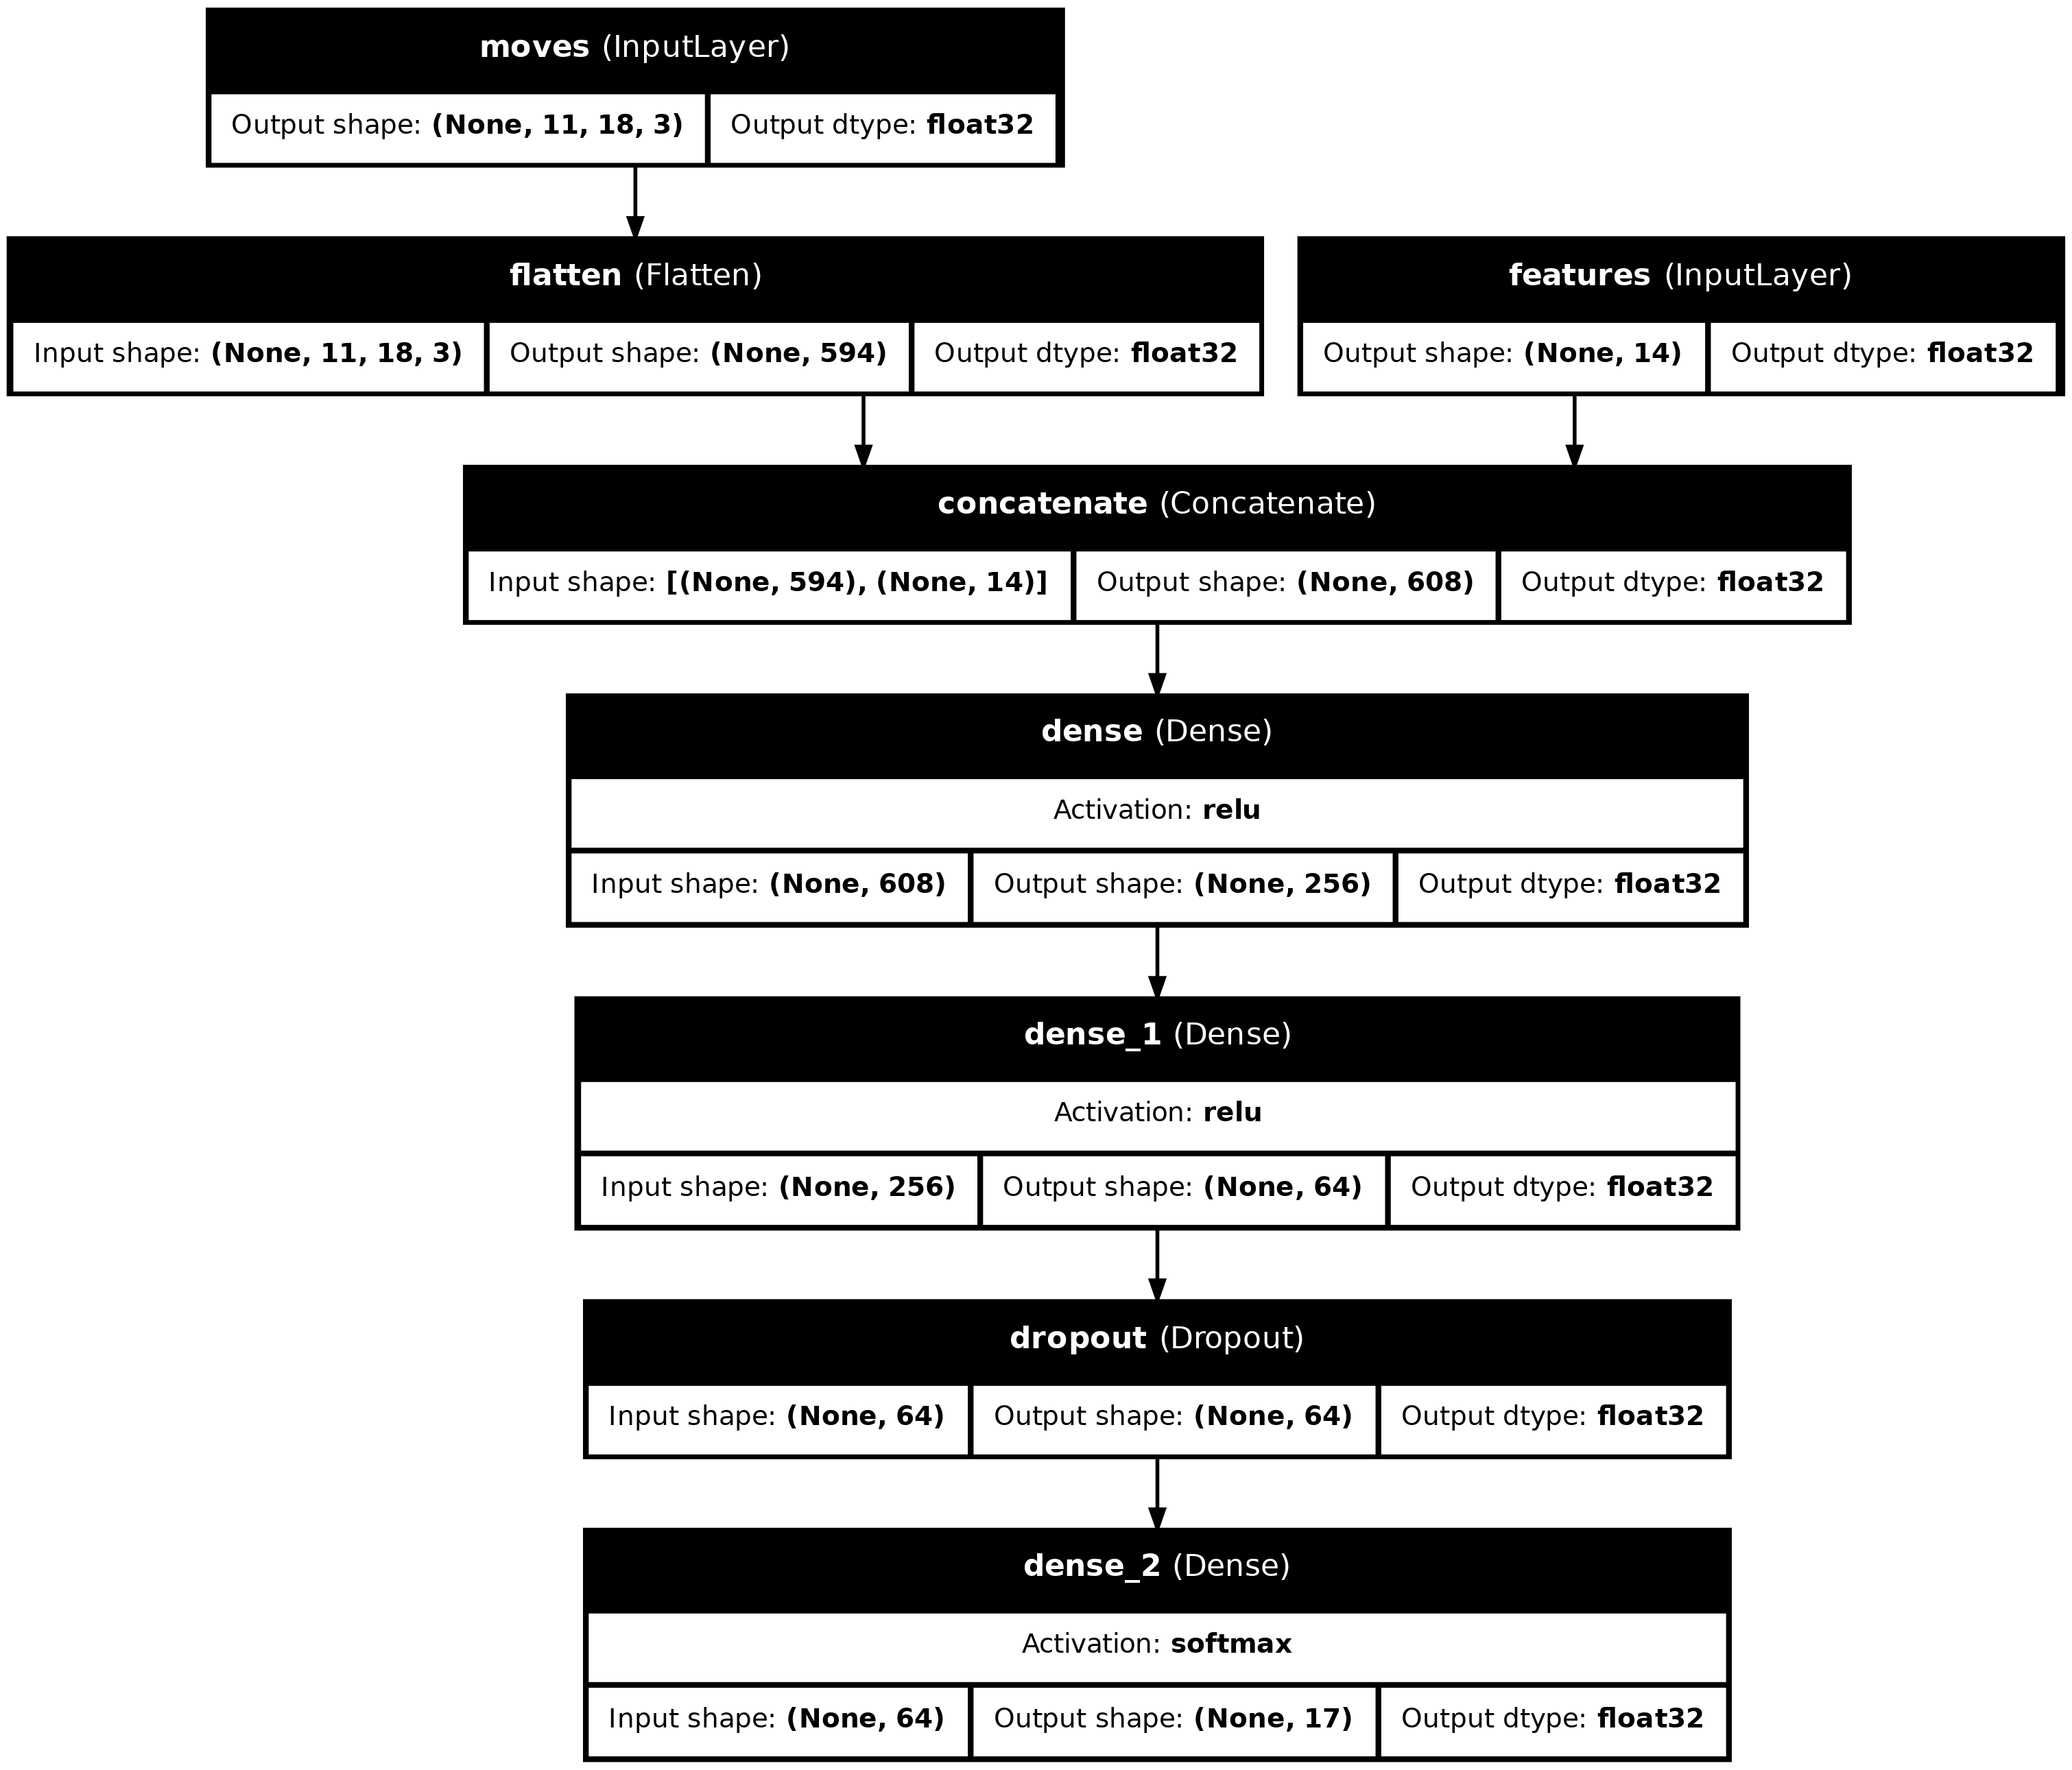

In [41]:
plot_model(baseline_model)
Image('model.png')

## Model training

In [ ]:
train_model(
  model=baseline_model,
  name='baseline',
  training_features=[train_moves, train_features],
  training_labels=train_labels,
  epochs=50,
  early_stopping=3
)

In [42]:
baseline_model, train_predicted, train_y_true, train_y_pred, test_predicted, test_y_true, test_y_pred = load_best_model('baseline')

2024-10-14 18:15:52.685508: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68001120 exceeds 10% of free system memory.
2024-10-14 18:15:52.791539: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68001120 exceeds 10% of free system memory.
I0000 00:00:1728922553.074954   38571 service.cc:146] XLA service 0x7fce600052a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728922553.075341   38571 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-10-14 18:15:53.196211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-14 18:15:53.417612: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1728922554.102502   38571 device_compiler.h:188] Compiled cluster using XLA!  This line is l

## Accuracy

In [43]:
print_accuracies(baseline_model, test_y_true, test_y_pred)

Accuracy: 34.48%
Balanced Accuracy: 17.54%
Accuracy for Top3: 68.28%
Accuracy for Top5: 86.37%


Our model is overfitting straight away: it's not able to detect any patterns, so it learns the training dataset by heart.

## Confusion matrix

Accuracy for grade 5+: 69.18%
Accuracy for grade 6A: 3.43%
Accuracy for grade 6A+: 61.66%
Accuracy for grade 6B: 5.48%
Accuracy for grade 6B+: 77.02%
Accuracy for grade 6C: 0.13%
Accuracy for grade 6C+: 4.73%
Accuracy for grade 7A: 39.32%
Accuracy for grade 7A+: 29.07%
Accuracy for grade 7B: 0.00%
Accuracy for grade 7B+: 8.24%
Accuracy for grade 7C: 0.00%
Accuracy for grade 7C+: 0.00%
Accuracy for grade 8A: 0.00%
Accuracy for grade 8A+: 0.00%
Accuracy for grade 8B: 0.00%
Accuracy for grade 8B+: 0.00%


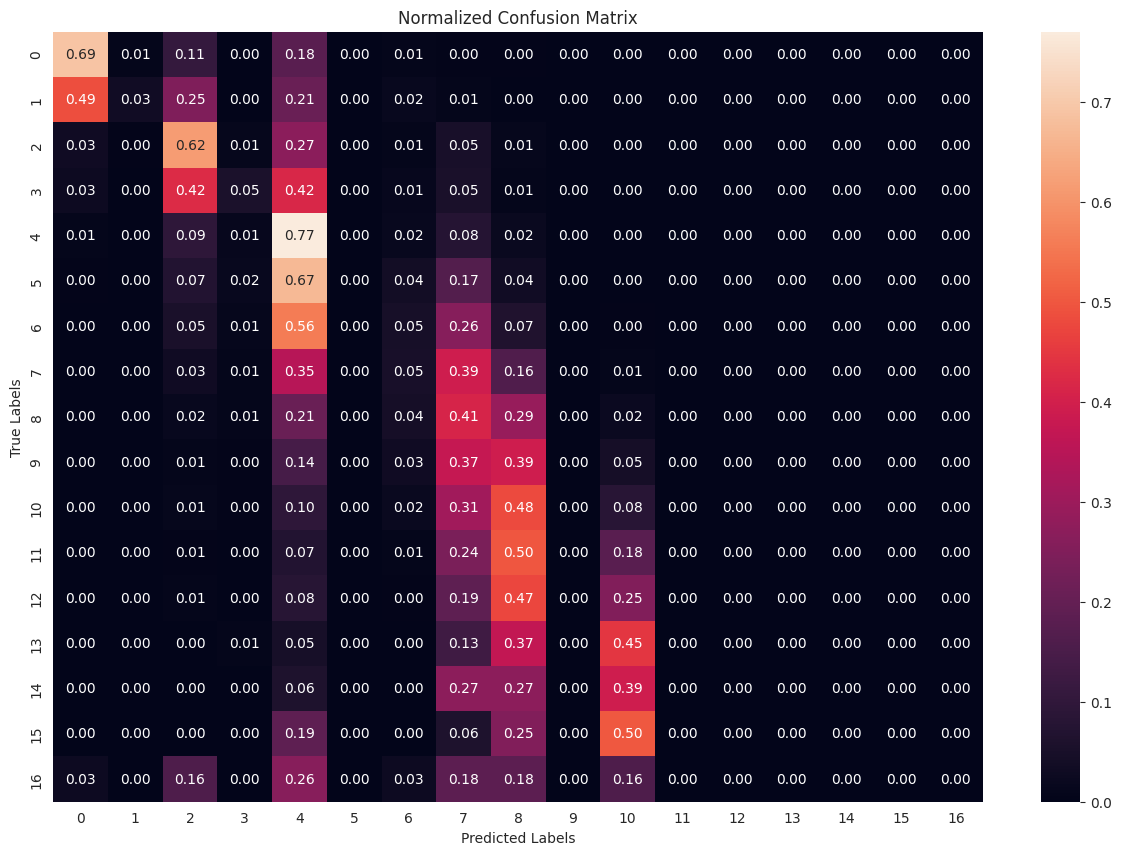

In [44]:
confusion_matrix_analysis(test_y_true, test_y_pred)

## One-vs-rest analysis

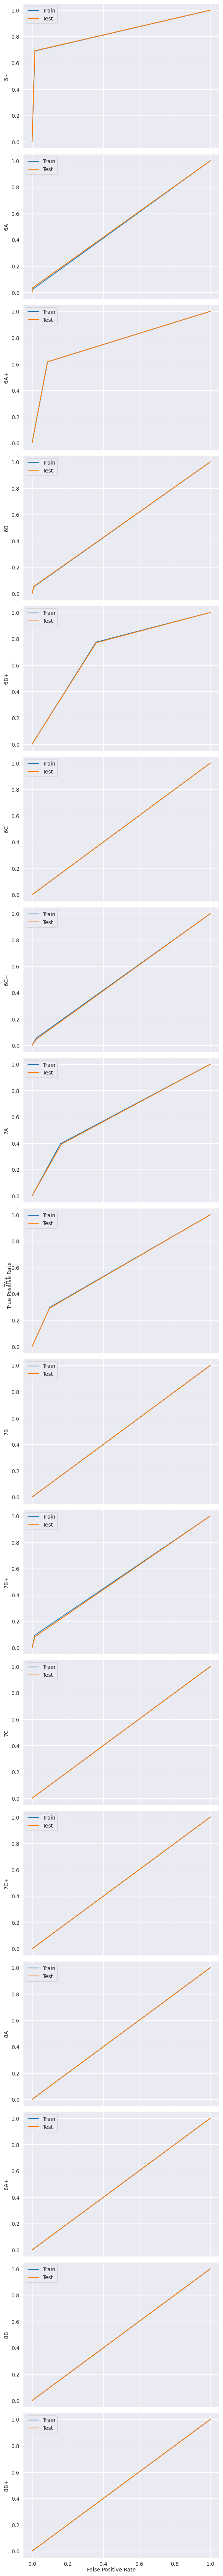

In [45]:
one_vs_rest_roc_curve(train_predicted, test_predicted)

For almost every grade, this baseline model doesn't achieve better performance than a random guess. At least, it's not worse.

For middle grades (around 6), we get the same insight as with the confusion matrix: the model achieves better performance. Thus the class imbalance has a clear impact and we must apply corrections before going further.

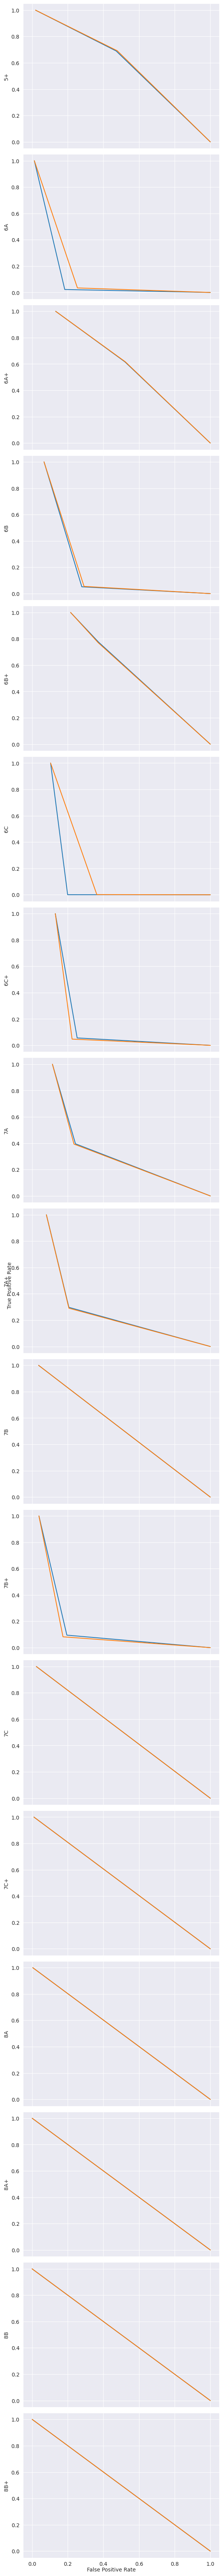

In [46]:
one_vs_rest_precision_recall_curve(train_predicted, test_predicted)

# Class weights

We'll use a Keras feature called class weights, that allow our model to take into account class imbalances and adapt its learning.

Here is the distribution of classes in the training dataset:

<Axes: >

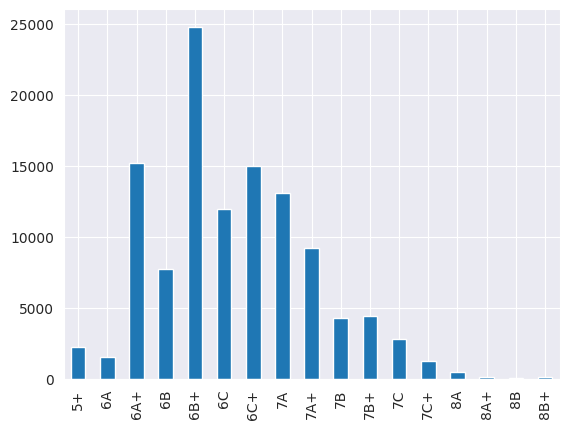

In [47]:
train_labels.sum().plot(kind='bar')

## Calculate class weights

In [48]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(nb_labels), y=np.argmax(train_labels, axis=1))
class_weight_dict = dict(enumerate(class_weights))

## Train model

In [ ]:
train_model(
  model=compile_model(build_function=create_baseline),
  name='baseline_weighted',
  training_features=[train_moves, train_features],
  training_labels=train_labels,
  class_weight=class_weight_dict,
  epochs=50,
)

This weighted training made the model overfit farther than before: the model started to learn some patterns.

## Accuracies

In [49]:
baseline_weighted, train_predicted, train_y_true, train_y_pred, test_predicted, test_y_true, test_y_pred = load_best_model('baseline_weighted')

2024-10-14 18:16:23.425958: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68001120 exceeds 10% of free system memory.
2024-10-14 18:16:23.493606: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68001120 exceeds 10% of free system memory.


In [50]:
print_accuracies(baseline_weighted, test_y_true, test_y_pred)

Accuracy: 28.77%
Balanced Accuracy: 24.13%
Accuracy for Top3: 59.40%
Accuracy for Top5: 78.95%


Global accuracies are less important, because they are too precise for our climbing problem.
 
Here, the balanced accuracy is better, which is a sign of our model generalizing more and not only skipping rare grades.

## Confusion matrix

Accuracy for grade 5+: 58.67%
Accuracy for grade 6A: 57.26%
Accuracy for grade 6A+: 39.92%
Accuracy for grade 6B: 54.78%
Accuracy for grade 6B+: 49.39%
Accuracy for grade 6C: 20.28%
Accuracy for grade 6C+: 3.69%
Accuracy for grade 7A: 16.42%
Accuracy for grade 7A+: 3.85%
Accuracy for grade 7B: 9.94%
Accuracy for grade 7B+: 34.38%
Accuracy for grade 7C: 7.87%
Accuracy for grade 7C+: 31.43%
Accuracy for grade 8A: 22.40%
Accuracy for grade 8A+: 0.00%
Accuracy for grade 8B: 0.00%
Accuracy for grade 8B+: 0.00%


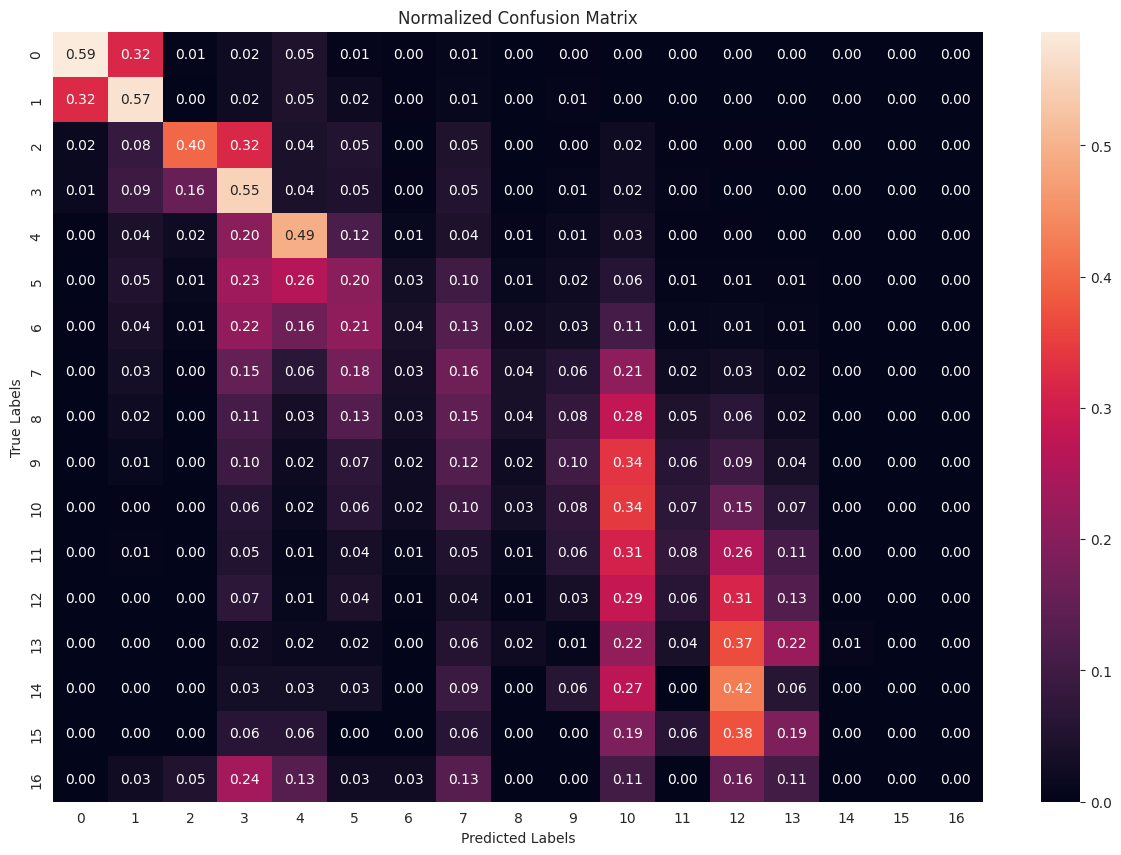

In [51]:
confusion_matrix_analysis(test_y_true, test_y_pred)

Predictions for easier grades are more concentrated on the diagonal, and our model now predicts difficult grades.

The new problem here is that our model tends to overestimate difficult routes (lower triangle is more filled in the sub-matrix [10:, 10:])

# Combine under-sampling and over-sampling

We'll try to keep all counts in range `[10000; 20000]` except for extreme classes (8A and further).

<Axes: >

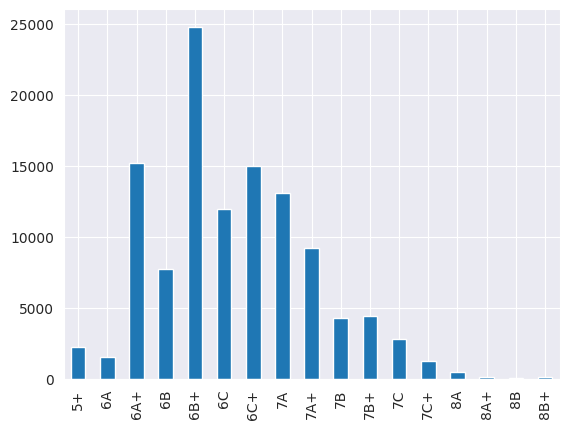

In [52]:
train_labels.sum().plot(kind='bar')

## Under-sampling

In [53]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(
  sampling_strategy={
    2: 10_000,
    4: 10_000,
    5: 10_000,
    6: 10_000,
    7: 10_000
  }
)
train_features_undersample, train_labels_undersample = under_sampler.fit_resample(train_features.values, train_labels.values)
train_moves_undersample, _ = under_sampler.fit_resample(train_moves.reshape(train_moves.shape[0], -1), train_labels.values)

## Over-sampling

In [55]:
from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(sampling_strategy={
  0: 10_000,
  1: 10_000,
  3: 10_000,
  8: 10_000,
  9: 10_000,
  10: 10_000,
  11: 10_000,
  12: 10_000,
  13: 5_000,
  14: 5_000,
  15: 5_000,
  16: 5_000,
})
train_combined_undersample = np.concatenate([train_features_undersample, train_moves_undersample], axis=1)

train_combined_resampled, train_labels_resampled = over_sampler.fit_resample(train_combined_undersample, train_labels_undersample)

In [56]:
train_features_resampled = train_combined_resampled[:, :nb_features]
train_moves_resampled = train_combined_resampled[:, nb_features:].reshape(-1, *train_moves.shape[1:])

In [57]:
train_labels_resampled.sum(axis=0)

array([10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000, 10000,  5000,  5000,  5000,  5000])

## Model training

In [ ]:
train_model(
  model=compile_model(build_function=create_baseline),
  name='baseline_resampled',
  training_features=[train_moves_resampled, train_features_resampled],
  training_labels=train_labels_resampled,
  epochs=50,
)

The training accuracy is the best of all, but the validation accuracy is the worst of all... training and validation lost curves keep the same distance for every epoch but with an important gap

# Treating routes as images: Convolution

During Data analysis, we chose to plot our routes as images, with the three separate channels representing the type of hold (start, middle, end). So, if our routes can be interpreted as images, why can't our problem be an image classification problem? That's what we will explore using Convolutional Neural Networks (CNN).

## Testing multiple configurations

Here, we try several different configurations using many techniques :

- Conv2D vs SeparableConv2D layers
- Number and shape of layers
- Padding, strides
- Residual connections
- Normalization in the middle of the model

In [58]:
def create_convolutional():
  shape = [32, 64, 128, 256]
  
  moves_inputs = keras.Input(shape=MOVES_SHAPE, name="moves")
  features_inputs = keras.Input(shape=(nb_features,), name="features")
  
  x = keras.layers.Dense(64, activation='relu')(features_inputs)
  features_outputs = keras.layers.Dense(64, activation='relu')(x)
  
  # The assumption for using depth wise-separable convolution is channel independence, which is not the case here.
  # The three channels are part of the same route, and only indicate the stage (start, middle, end)
  y = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(moves_inputs)
  
  for i, filters in enumerate(shape):
    connection = y
  
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)
    y = keras.layers.SeparableConv2D(filters=filters, kernel_size=3, padding='same', use_bias=False)(y)

    y = keras.layers.MaxPool2D(pool_size=2, padding='same')(y)
          
    # Residual connection fit
    connection = keras.layers.Conv2D(filters=filters, kernel_size=1, strides=2, padding='same', use_bias=False)(connection)
          
    y = keras.layers.add((y, connection))
  
  moves_outputs = keras.layers.GlobalAveragePooling2D()(y)
  
  x = keras.layers.concatenate([features_outputs, moves_outputs])
  
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(nb_labels, activation='softmax')(x)
  
  return keras.Model(inputs=[moves_inputs, features_inputs], outputs=outputs)

In [59]:
convolution_model = compile_model(build_function=create_convolutional)

In [60]:
plot_model(convolution_model)
Image('model.png')

In [ ]:
train_model(
  model=convolution_model,
  name='convolution',
  training_features=[train_moves, train_features],
  training_labels=train_labels,
  epochs=70
)

### Observations

- Overfitting is far away, many epochs can be achieved
- Padding don't cause underfitting, but augmenting the end dense network yes
- Better performances by normalizing after layers and adding residual connections

## Using a learning rate schedule

In [ ]:
convolution_model = compile_model(build_function=create_convolutional, learning_rate=1e-4)
train_model(
  model=convolution_model,
  name='convolution-schedule',
  # class_weight=class_weight_dict,
  callbacks=[
    keras.callbacks.ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.4,
      patience=2,
      min_lr=1e-6
    )
  ],
  training_features=[train_moves, train_features],
  training_labels=train_labels,
  epochs=70
)

### Observations

- Slightly better performance when reducing the learning rate to 1e-4
- Reduce LR on plateau: only efficient on training validation, as the LR starts to reduce when the model is overfitting
- 1e-7 is too low: the loss is not decreasing

Conclusion: for this problem, a constant learning rate seems to be the most efficient method

## Accuracies

In [61]:
best_convolution, train_predicted, train_y_true, train_y_pred, test_predicted, test_y_true, test_y_pred = load_best_model('convolution-schedule')

2024-10-14 18:17:35.495197: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68001120 exceeds 10% of free system memory.
W0000 00:00:1728922656.483863   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922656.635379   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922656.670609   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922656.685105   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922656.687277   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922656.689435   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922656.691652   38571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1

In [62]:
print_accuracies(best_convolution, test_y_true, test_y_pred)

Accuracy: 40.26%
Balanced Accuracy: 23.08%
Accuracy for Top3: 76.43%
Accuracy for Top5: 92.03%


Overall accuracy is the best so far, but balanced accuracy is worse than with class weights. We can add this last technique to further improve our model.

# Explainability

We now try to explain the results of our model, by using Shap and visualisation techniques. These last work well with Convolutional Neural Network to plot the filters and get an insight of what's happening.

## Features importance

In [63]:
import shap

explainer = shap.GradientExplainer(best_convolution, [train_moves, train_features.values])

# Shape of shap_values
# - First element: (nb_samples, WIDTH, HEIGHT, CHANNELS, nb_outputs)
# - Second element: (nb_samples, nb_features, nb_labels)
shap_values = explainer.shap_values([test_moves[:4], test_features.values[:4]])

W0000 00:00:1728922678.931543   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.934998   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.938028   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.942362   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.944432   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.946642   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.948949   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.952511   38365 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728922678.954662   38365 gp

Text(-350, -30, '7A 6A+ 6B+ 6C+')

<Figure size 6000x1000 with 0 Axes>

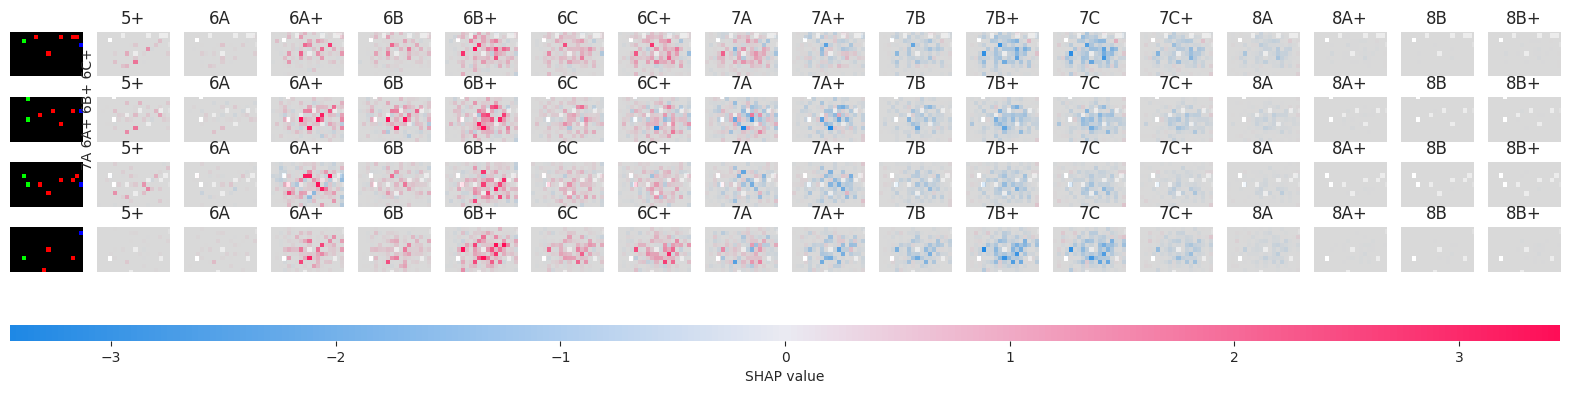

In [64]:
plt.figure(figsize=(60, 10))
shap.image_plot(
  [shap_values[0][:, :, :, :, i] for i in range(nb_labels)],
  test_moves[:4] * 255,
  labels=np.tile(all_grades, (nb_labels, 1)),
  show=False
)
plt.text(-350, -30, ' '.join(np.vectorize(lambda i: all_grades[i])(np.flip(test_y_pred[:4]))), va='center', rotation='vertical')

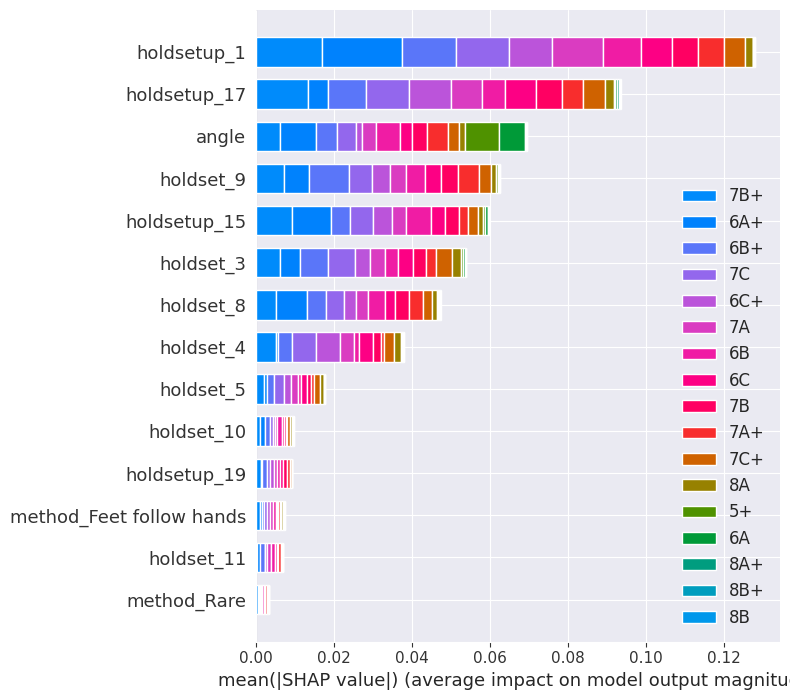

In [65]:
shap.summary_plot(
  [shap_values[1][:, :, i] for i in range(nb_labels)],
  plot_type='bar',
  class_names=all_grades,
  feature_names=features.columns
)

- Board angle has the most influence on the grade, as it's more difficult to climb a steep route. It has almost an equal importance for all grades, if we take into account class imbalance
- Method has the least influence: not fully using feet doesn't make the route more difficult ; it's likely to be due to strong angles on moonboards (25° and 40°), thus the majority of the effort done by the climber is located in the arms and chest

## Filters visualisation (TODO)

# Conclusions

The conclusion will be written when the project has been completed, so after testing different configurations to reach the best performances, as well as explaining these results. Stay tuned!